In [ ]:
# import libraries
import tensorflow as tf
import keras
from matplotlib import pyplot as plt
from nn_models import Network
from tqdm import tqdm
import math
from muzeroconfig import MuZeroConfig
from nn_models import Network, NetworkOutput
import copy
from typing import List
import numpy as np


<h1>MuZero Agent playing Boardgames</h1>
<h2>Class Wrappers for general boardgame usage</h2>

In [ ]:
# we define the abstract class Wrappers to store and describe the game state for MuZero observation and action representatoin
class Action(object):

    def __init__(self, index: int):
        # savety mechanism to ensure that the index is an integer
        if np.issubdtype(type(index), int) :
            self.index = index
        else:
            self.index = index.index

    def __hash__(self):# hash function to store Actions in a dictionary
        return self.index

    def __eq__(self, other):# equality test to compare Actions with eachother
        return self.index == other.index

    def __gt__(self, other): # non-equality test to compare Actions with eachother
        return self.index > other.index

    def __str__(self): # string representation of the Action for printing
        return str(self.index)


class Player(object):
    def __init__(self, index: int):# Same as for Action class
        self.index = index
    def __hash__(self):
        return self.index
    def __eq__(self, other):
        return self.index == other.index
    def __gt__(self, other):
        return self.index > other.index
    def __str__(self):
        return str(self.index)


class ActionHistory(object):
    # We store the past Actions inside this storage container to use them for training
    def __init__(self, history: List[Action], action_space_size: int, player):
        self.history = history
        self.action_space_size = action_space_size
        self.player = player
    def clone(self): # clone the ActionHistory
        return ActionHistory(self.history, self.action_space_size, self.player)
    def add_action(self, action: Action): # add an Action to the history
        self.history.append(action)
    def last_action(self) -> Action:# return the last Action
        return self.history[-1]
    def action_space(self) -> List[Action]:# return the Action space
        return [Action(i) for i in range(self.action_space_size)]
    def to_play(self):  # return the player to play
        return Player(self.player)


class Node(object):
# Nodes represent Game states from which we can expand the search tree
    def __init__(self, prior: float):
# every Node has a visit count, a prior probability, a value sum, a list of children, a hidden state, a reward and a player to play
        self.visit_count = 0
        self.to_play = 1
        self.prior = prior
        self.value_sum = 0
        self.children = {}
        self.hidden_state = None
        self.reward = 0

    def expanded(self) -> bool: # checks if the node has already been expanded
        return len(self.children) > 0

    def value(self) -> float: # returns the value of the node
        if self.visit_count == 0:
            return 0
        else:
            return self.value_sum / self.visit_count

In [ ]:
class MinMaxStats:
    """Class For storing MinMax values of Nodes"""
    def __init__(self):
        self.maximum =-float('inf')
        self.minimum = float('inf')
    def update(self, value: float):
        self.maximum = max(self.maximum, value)
        self.minimum = min(self.minimum, value)
    def normalize(self, value: float) -> float:
        if self.maximum > self.minimum:
            return (value - self.minimum) / (self.maximum - self.minimum)
        return value

class MCTS:
    """A class that runs Monte Carlo Tree Search. We use the UCB1 formula. to select a child and search from there"""
    @staticmethod
    def play_game(config: MuZeroConfig, network: Network):
        game = config.new_game()

        while not game.done and len(game.board.game_history) < config.max_moves:
            # At the root of the search tree we use the representation function to to get a hidden state from observation
            root = Node(0)
            current_observation = game.get_observation()
            # expand different board actions
            MCTS.expand_node(root,
                        game.to_play(),
                        game.legal_actions(),
                        network.initial_inference(current_observation))
            MCTS.add_exploration_noise(config, root)
            # running the MCTS using the network for evaluating positions and choosing actions
            MCTS.run_mcts(config,root, game, network)
            action = MCTS.select_action(config, root, network)
            game.store_search_statistics(root)
            game.apply(action)
        return game

    @staticmethod
    def run_mcts(config: MuZeroConfig,
                 root: Node,
                 game,
                 network: Network):
        # store minmax values
        min_max_stats = MinMaxStats()
        #copy game state to avoid changing the original game when running MCTS
        game_copy = copy.deepcopy(game)
        # we simulate the game for congig.num_simulations times
        for _ in range(config.num_simulations):

            history = game_copy.get_action_history()
            node = root
            search_path = [node]

            while node.expanded():
                action, node = MCTS.select_child(config, node, min_max_stats)
                game_copy.apply(action)
                history.add_action(action)
                search_path.append(node)
            # When traversing the tree we use the dynamics network to predict next states
            parent = search_path[-2]
            network_output = network.recurrent_inference(parent.hidden_state,
                                                         history.last_action())
            (MCTS.expand_node(node, history.to_play(), game_copy.legal_actions(), network_output))
            MCTS.backpropagate(search_path,
                          network_output.value,
                          history.to_play(),
                          config.discount,
                          min_max_stats)
            if game_copy.done:
                break
        del game_copy
    @staticmethod # take a softmax sample from a given distribution
    def softmax_sample(distribution, temperature: float):
        visit_counts = np.array([visit_counts for _ , visit_counts in distribution])
        actions = np.array([actions for actions , _ in distribution])
        visit_counts_exp = np.exp(visit_counts)
        policy = visit_counts_exp / np.sum(visit_counts_exp)
        policy = (policy ** (1 / temperature)) / (policy ** (1 / temperature)).sum()
        action_index = np.random.choice(actions, p=policy)

        return action_index
    @staticmethod
    def select_action(config,
                      node: Node,
                      network: Network) -> Action:
        visit_counts = [(action,child.visit_count) for action, child in node.children.items()]
        t = config.visit_softmax_temperature(training_steps=network.training_steps())
        action = Action(MCTS.softmax_sample(visit_counts, t))
        return action

    # Select the child with the highest UCB score.
    @staticmethod
    def select_child(config: MuZeroConfig, node: Node, min_max_stats: MinMaxStats):
        _, action, child = max(
            (MCTS.ucb_score(config, node, child, min_max_stats), action, child) for action, child in node.children.items())
        return action, child

    # The score for a node is based on its value, plus an exploration bonus based on the prior.
    @staticmethod
    def ucb_score(config: MuZeroConfig, parent: Node, child: Node, min_max_stats: MinMaxStats) -> float:
        pb_c = math.log((parent.visit_count + config.pb_c_base + 1) / config.pb_c_base) + config.pb_c_init
        pb_c *= math.sqrt(parent.visit_count) / (child.visit_count + 1)
        prior_score = pb_c * child.prior
        if child.visit_count > 0:
            value_score = min_max_stats.normalize(child.reward + config.discount * child.value())
        else:
            value_score = 0
        return prior_score + value_score

    # We expand a node using the value, reward and policy prediction obtained from the neural network.
    @staticmethod
    def expand_node(node: Node, to_play: Player, actions: List[Action], network_output: NetworkOutput):
        node.to_play = to_play
        node.hidden_state = network_output.hidden_state
        node.reward = network_output.reward
        policy = {a: math.exp(network_output.policy_logits[a]) for a in actions}
        policy_sum = sum(policy.values())
        for action, p in policy.items():
            node.children[action] = Node(p / policy_sum)

    # At the end of a simulation, we propagate the evaluation all the way up the tree to the root.
    @staticmethod
    def backpropagate(search_path: List[Node], value: float, to_play: Player, discount: float,
                      min_max_stats: MinMaxStats):
        for node in reversed(search_path):
            node.value_sum += value if node.to_play == to_play else -value
            node.visit_count += 1
            min_max_stats.update(node.value())

            value = node.reward + discount * value


    @staticmethod # We add noise to the distribution to encourage exploration
    def add_exploration_noise(config: MuZeroConfig, node: Node):
        actions = list(node.children.keys())
        noise = np.random.dirichlet([config.root_dirichlet_alpha] * len(actions))
        frac = config.root_exploration_fraction
        for a, n in zip(actions, noise):
            node.children[a].prior = node.children[a].prior * (1 - frac) + n * frac


class NetworkStorage(object):
    def __init__(self, config):
        self.network = Network(config)

    def save_network(self,network):
        self.network = network

    def latest_network(self):
        return self.network



class GameStorage(object):
    def __init__(self, config: MuZeroConfig):
        self.window_size = config.window_size
        self.batch_size = config.batch_size
        self.store = []

    def save_game(self, game):
        if len(self.store) > self.window_size:
            self.store.pop(0)
        self.store.append(game)

    def sample_batch(self, num_unroll_steps: int, td_steps: int, action_space_size: int):
        games = [self.sample_game() for _ in range(self.batch_size)]
        game_pos = [(g, self.sample_position(g)) for g in games]
        return [(g.observation_list[i],
                 g.action_history[i:i + num_unroll_steps],
                 g.make_target(state_index=i,num_unroll_steps=num_unroll_steps, td_steps=td_steps))
                for (g, i) in game_pos]

    def sample_game(self):
        # get games from the gamestorage
        return self.store[np.random.choice(range(len(self.store)))]

    def sample_position(self, game) -> int:
        # sample a postion from the game
        return np.random.choice(range(len(game.rewards) - 1))

    def last_game(self):
        return self.store[-1]


<h2>Game specific MuZero configuration</h2>
this is the parent class for creating a Game-Dependent Muzero Agent configuration. we inherit from this class to build agents

In [ ]:
class MuZeroConfig(object):
    def __init__(self,
                 action_space_size: int,
                 observation_space_size: int,
                 observation_space_shape: (int,int),
                 max_moves: int,
                 discount: float,
                 dirichlet_alpha: float,
                 num_simulations: int,
                 batch_size: int,
                 td_steps: int,
                 num_actors: int,
                 lr_init: float,
                 lr_decay_steps: float,
                 dropout_rate: float,
                 training_episodes: int,
                 hidden_layer_size: int,
                 model_name: str,
                 visit_softmax_temperature,
                 ):
        ### Self-Play
        self.action_space_size = action_space_size
        self.observation_space_size = observation_space_size
        self.observation_space_shape = observation_space_shape
        self.num_actors = num_actors

        self.visit_softmax_temperature = visit_softmax_temperature
        self.max_moves = max_moves
        self.num_simulations = num_simulations
        self.discount = discount

        # Root prior exploration noise.
        self.root_dirichlet_alpha = dirichlet_alpha
        self.root_exploration_fraction = 0.25

        # UCB formula
        self.pb_c_base = 19652
        self.pb_c_init = 1.25

        ### Training
        # We discard old games after every bage to save on RAM memory
        self.window_size = batch_size
        self.batch_size = batch_size
        # num of steps top unroll for MCTS
        self.num_unroll_steps = 3
        self.td_steps = td_steps
        # optimization parameters
        self.weight_decay = 1e-4
        self.momentum = 0.9
        self.training_episodes = training_episodes
        # Network params
        self.hidden_layer_size = hidden_layer_size
        self.dropout_rate = dropout_rate
        # Exponential learning rate schedule
        self.lr_init = lr_init
        self.lr_decay_steps = lr_decay_steps
        self.lr_decay_rate = 0.1

        self.model_name = model_name

    def new_game(self):
        return Game(self.action_space_size, self.discount)

class Game:
    def __init__(self, action_space_size, discount):
        self.action_space_size = action_space_size
        self.discount = discount
        self.observation_history = []
        self.action_history = []
        self.rewards = []

In [ ]:
from go_board import GoBoard
from go_utils import GoUtils
# import Go implementation

class Go7x7Config(MuZeroConfig):
# inherit from configuration class
    def new_game(self): # function to create a new game
        return Go7x7()

# pass the configuration for the game sepcific agent
def make_Go7x7_config() -> MuZeroConfig:
    # we use a temperature schedule to control the exploration rate of the agent
    def visit_softmax_temperature(training_steps):

        if training_steps < 100:
            return 3
        elif training_steps < 125:
            return 2
        elif training_steps < 150:
            return 1
        elif training_steps < 175:
            return 0.5
        elif training_steps < 200:
            return 0.250
        elif training_steps < 225:
            return 0.125
        else:
            return 0.125

    return Go7x7Config(action_space_size= 50,
                        observation_space_size= 49,
                        observation_space_shape= (7,7),
                        max_moves=98,
                        discount=0.999,
                        dropout_rate = 0.1,
                        dirichlet_alpha=0.25,
                        num_simulations=10,
                        batch_size=16,
                        td_steps=25,
                        lr_init=0.001,
                        lr_decay_steps=10,
                        training_episodes=500,
                        hidden_layer_size= 49,
                        visit_softmax_temperature=visit_softmax_temperature,
                        num_actors=2,
                        model_name="Go7x7")

# This function is used to create a new game with which the agent can interact
class Go7x7:
    def __init__(self):
        self.board_size = 7
        self.player = 1 # Black goes first
        self.board = GoBoard(board_dimension=self.board_size, player=self.player) # from go_board.py
        self.utils = GoUtils() # from go_utils.py
        self.observation_space_shape = (self.board_size,self.board_size)
        self.observation_space_size = self.board_size**2
        self.action_space_size = (self.board_size**2)+1
        self.action_history = []
        # sto store rewards for training
        self.rewards = []
        # to store board states for training
        self.observation_list = []
        # to store the visit counts and values of the nodes
        self.child_visits = []
        self.root_values = []
        self.discount = 0.999
        self.done = False
   
   # does a step in the game
    def step(self, action):
        r = int(np.floor(action / self.board_size))
        c = int(action % self.board_size)
        move = (r,c)
        if action == self.board_size**2:
            move = (-1,-1)
            #check if move is viable
        move_viable, self.board = self.utils.make_move(board=self.board,move=move)
        # punish the agent if he does an illegal move
        if not move_viable:
            done = True
            reward = -1
            return self.get_observation(), reward, done
        # check if the game is finished by definition (2 passes)
        done = self.utils.is_game_finished(board=self.board)
        if done and move_viable:
            reward = 1 if self.utils.evaluate_winner(board_grid=self.board.board_grid)[0] == self.player else -1
        elif not done and move_viable:
            reward = 0
        return self.get_observation(), reward, done
    # apply one interaction between agent and environment, store the reward and observation
    def apply(self, action: Action):
        observation, reward, done = self.step(action.index)
        self.rewards.append(reward)
        self.action_history.append(action.index)
        self.observation_list.append(observation)
        self.done = done
    
    # get the observation of the current game state
    def get_observation(self):
        return tf.constant([self.board.board_grid],dtype="int32")
    # return the legal actions for the current game state
    def legal_actions(self)-> List[Action]:
        # Pass = boardsize**2 is always legal
        legal = [self.board_size**2]
        for i in range(self.board_size):
            for j in range(self.board_size):
                if self.utils.is_valid_move(board=self.board,move=(i,j)):
                    legal.append(i * self.board_size + j)
        return [Action(index) for index in legal]
    # return the the total reward of the game
    def total_rewards(self):
        return sum(self.rewards)
    # return if game is finished
    def is_finished(self):
        finished = self.utils.is_game_finished(board=self.board)
        if finished:
            print("game is finished!")
        return finished
    # return the player to play
    def to_play(self):
        return Player(self.board.player)
    # return the action history
    def get_action_history(self) -> ActionHistory:

        return ActionHistory(self.action_history, self.action_space_size,self.board.player)
    # store the visit counts and values of the nodes
    def store_search_statistics(self, root: Node):
        # We store the visited board positions and their values for later training
        sum_visits = sum(child.visit_count for child in root.children.values())
        action_space = (Action(action) for action in range(self.action_space_size))
        self.child_visits.append([
            root.children[a].visit_count / sum_visits if a in root.children else 0
            for a in action_space
        ])
        self.root_values.append(root.value())
    # return the targets for training
    def make_target(self, state_index: int, num_unroll_steps: int, td_steps: int):
        # Bootsstapping technique to calculate the value of a state
        targets = []
        for current_index in range(state_index, state_index + num_unroll_steps + 1):
            bootstrap_index = current_index + td_steps
            if bootstrap_index < len(self.root_values):
                value = self.root_values[bootstrap_index] * self.discount ** td_steps
            else:
                value = 0

            for i, reward in enumerate(self.rewards[current_index:bootstrap_index]):
                value += reward * self.discount ** i  # pytype: disable=unsupported-operands

            if current_index > 0 and current_index <= len(self.rewards):
                last_reward = self.rewards[current_index - 1]
            else:
                last_reward = 0

            if current_index < len(self.root_values):
                targets.append((value, last_reward, self.child_visits[current_index]))
            else:
                # States past the end of games are treated as absorbing states.
                targets.append((0, last_reward, []))
        return targets


if __name__ == "__main__":
    pass

We created the same, uncommented configuration file for the Go9x9 game
<h2>Network Architecture</h2>

In [ ]:
import numpy as np
from Wrappers import Action
from typing import NamedTuple, Dict, List
from keras import layers
import tensorflow as tf
import keras
from tensorflow.python.keras.regularizers import L2


'''
Impementation of neural network in muzero algorithm for 7x7 game board

There are 4 networks:
- The Representation network 
- The Value network
- The Policy network
- The Reward network 
'''
# Avstract class for the network output
class NetworkOutput(NamedTuple):
    value: float
    reward: float
    policy_logits: Dict[Action, float]
    policy_tensor: List[float]
    hidden_state: List[float]

# Network class
class Network(object):

    def __init__(self, config):
        self.hidden_layer_size = config.hidden_layer_size
        self.observation_space_shape = (1,) + config.observation_space_shape + (1,)
        regularizer = L2(config.weight_decay)


        #state encoder conv network
        self.representation = keras.Sequential()
        self.representation.add(layers.Conv2D(64, (3, 3),activation='relu',kernel_regularizer=regularizer))
        self.representation.add(layers.Conv2D(64, (2, 2), activation='relu', kernel_regularizer=regularizer))
        self.representation.add(layers.Conv2D(64, (2, 2), activation='relu', kernel_regularizer=regularizer))
        self.representation.add(layers.Flatten())
        self.representation.add(layers.Dense(64, activation="relu", kernel_regularizer=regularizer))
        self.representation.add(layers.Dropout(config.dropout_rate))
        self.representation.add(layers.Dense(64, activation="relu", kernel_regularizer=regularizer))
        self.representation.add(layers.Dropout(config.dropout_rate))
        self.representation.add(layers.Dense(config.hidden_layer_size, kernel_regularizer=regularizer))

        #value network MLP
        self.value = keras.Sequential()
        self.value.add(layers.Dense(config.hidden_layer_size, activation='relu', kernel_regularizer=regularizer))
        self.value.add(layers.Dense(512, activation="relu", kernel_regularizer=regularizer))
        self.value.add(layers.Dropout(config.dropout_rate))
        self.value.add(layers.Dense(512, activation="relu", kernel_regularizer=regularizer))
        self.value.add(layers.Dropout(config.dropout_rate))
        self.value.add(layers.Dense(256, activation="relu", kernel_regularizer=regularizer))
        self.value.add(layers.Dense(128, activation="relu", kernel_regularizer=regularizer))
        self.value.add(layers.Dense(1,activation='relu', kernel_regularizer=regularizer))

        # policy network conv
        self.policy = keras.Sequential()
        self.policy.add(layers.Dense(config.hidden_layer_size, activation='relu', kernel_regularizer=regularizer))
        self.policy.add(layers.Dense(512, activation="relu", kernel_regularizer=regularizer))
        self.policy.add(layers.Dropout(config.dropout_rate))
        self.policy.add(layers.Dense(512, activation="relu", kernel_regularizer=regularizer))
        self.policy.add(layers.Dropout(config.dropout_rate))
        self.policy.add(layers.Dense(256, activation="relu", kernel_regularizer=regularizer))
        self.policy.add(layers.Dense(128, activation="relu", kernel_regularizer=regularizer))
        self.policy.add(layers.Dense(config.action_space_size, activation='softmax', kernel_regularizer=regularizer))

        #reward net MLP
        self.reward = keras.Sequential()
        self.reward.add(layers.Dense(config.hidden_layer_size, activation='relu', kernel_regularizer=regularizer))
        self.reward.add(layers.Dense(512, activation="relu", kernel_regularizer=regularizer))
        self.reward.add(layers.Dropout(config.dropout_rate))
        self.reward.add(layers.Dense(512, activation="relu", kernel_regularizer=regularizer))
        self.reward.add(layers.Dropout(config.dropout_rate))
        self.reward.add(layers.Dense(256, activation="relu", kernel_regularizer=regularizer))
        self.reward.add(layers.Dense(128, activation="relu", kernel_regularizer=regularizer))
        self.reward.add(layers.Dense(1,activation='relu', kernel_regularizer=regularizer))


        self.dynamics = keras.Sequential()
        self.dynamics.add(layers.Dense(config.hidden_layer_size, activation='relu', kernel_regularizer=regularizer))
        self.dynamics.add(layers.Dense(512, activation="relu", kernel_regularizer=regularizer))
        self.dynamics.add(layers.Dropout(0.2))
        self.dynamics.add(layers.Dense(1024, activation="relu", kernel_regularizer=regularizer))
        self.dynamics.add(layers.Dropout(0.2))
        self.dynamics.add(layers.Dense(512, activation="relu", kernel_regularizer=regularizer))
        self.dynamics.add(layers.Dense(config.hidden_layer_size, kernel_regularizer=regularizer))

        self.compile(optimizer=keras.optimizers.legacy.Adam(),metrics=['accuracy'], loss='mean_squared_error')

        self.tot_training_steps = 0
        self.backup_count = 0

        self.action_space_size = config.action_space_size

    def compile(self,loss, optimizer, metrics):
        self.dynamics.compile(optimizer=optimizer,loss=loss,metrics=metrics)
        self.representation.compile(optimizer=optimizer,loss=loss,metrics=metrics)
        self.value.compile(optimizer=optimizer,loss=loss,metrics=metrics)
        self.policy.compile(optimizer=optimizer,loss=loss,metrics=metrics)
        self.reward.compile(optimizer=optimizer,loss=loss,metrics=metrics)
    # for summarizing the network. Run this cell to get a summary of the network
    def summarise(self):
        self.representation.build(self.observation_space_shape)
        self.value.build((0,100))
        self.policy.build(self.observation_space_shape)
        self.reward.build((0,100))
        self.dynamics.build((0,100))

        print(self.representation.summary(),
        self.value.summary(),
        self.policy.summary(),
        self.reward.summary(),
        self.dynamics.summary(),
              )

    # initial inference for the representation network
    def initial_inference(self, image) -> NetworkOutput:
        # representation + prediction function
        image = tf.expand_dims(image, axis= 3)
        image = tf.cast(image, dtype=tf.float32)
        hidden_state = self.representation(image)

        #check if tensor is non-zero, if so only then normalize to avoid nan's
        zero_check = tf.reduce_all(tf.equal(hidden_state, 0.0))
        if not zero_check:
            hidden_state = tf.linalg.normalize(hidden_state)[0]

        value = self.value(hidden_state)
        policy = self.policy(hidden_state)
        reward = tf.constant([[0]], dtype=tf.float32)
        policy_p = policy[0]
        return NetworkOutput(value,
                             reward,
                             {Action(a): policy_p[a] for a in range(len(policy_p))},
                             policy,
                             hidden_state)
    
# recurrent inference for the dynamics, reward, value and policy network
    def recurrent_inference(self, hidden_state, action) -> NetworkOutput:
        # dynamics + prediction function
        a = hidden_state.numpy()[0]
        b = np.eye(self.action_space_size)[action.index]
        nn_input = np.concatenate((a, b))
        nn_input = np.expand_dims(nn_input, axis=0)

        next_hidden_state = self.dynamics(nn_input)

        # next_hidden_state = tf.keras.utils.normalize(next_hidden_state)

        reward = self.reward(nn_input)
        value = self.value(next_hidden_state)
        policy = self.policy(next_hidden_state)
        policy_p = policy[0]

        return NetworkOutput(value,
                             reward,
                             {Action(a): policy_p[a] for a in range(len(policy_p))},
                             policy,
                             next_hidden_state)

    def get_weights(self):
        # Returns the weights of this network.

        networks = (self.representation,
                    self.value,
                    self.policy,
                    self.dynamics,
                    self.reward)
        return [variables
                for variables_list in map(lambda n: n.weights, networks)
                for variables in variables_list]

    def training_steps(self) -> int:
        # How many steps / batches the network has been trained for.
        return self.tot_training_steps
    # save the network
    def save_network_deepcopy(self,model_name):

        self.representation.save(f"../Saved models/{model_name}/backup{self.backup_count}/representation_network")
        self.value.save(f"../Saved models/{model_name}/backup{self.backup_count}/value_network")
        self.dynamics.save(f"../Saved models/{model_name}/backup{self.backup_count}/dynamics_network")
        self.policy.save(f"../Saved models/{model_name}/backup{self.backup_count}/policy_network")
        self.reward.save(f"../Saved models/{model_name}/backup{self.backup_count}/reward_network")
    # load the network
    def load_network_deepcopy(self, model_name, backup_count):
        self.representation = keras.models.load_model(
            f"../Saved models/{model_name}/backup{backup_count}/representation_network")
        self.value = keras.models.load_model(f"../Saved models/{model_name}/backup{backup_count}/value_network")
        self.dynamics = keras.models.load_model(f"../Saved models/{model_name}/backup{backup_count}/dynamics_network")
        self.policy = keras.models.load_model(f"../Saved models/{model_name}/backup{backup_count}/policy_network")
        self.reward = keras.models.load_model(f"../Saved models/{model_name}/backup{backup_count}/reward_network")


if __name__ == "__main__":
    network =Network(make_Go7x7_config())
    #network.load_network_deepcopy(model_name="Go7x7", backup_count=4) # This is how to load a network
    network.summarise()

<h2>Main Training Loop of the Agent</h2>

In [ ]:
# to check and install GPU
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print("TensorFlow is using GPU: ", tf.test.is_gpu_available())

# We reapeteatly create moves from mcts
def run_selfplay(config: MuZeroConfig,
                 storage: NetworkStorage,
                 game_storage: GameStorage,
                 iteration: int):
    mcts = MCTS()
    for _ in tqdm(range(config.batch_size), desc="Selfplay Batch creation", position=1, leave=True):
        # load network from network save
        network = storage.latest_network()
        game = mcts.play_game(config,network)
        #store the game inside of a container
        game_storage.save_game(game)
    print(f"Batch {iteration} creation completed. Starting training...")


def scalar_loss(prediction, target) -> float:
    # calculating mean squared error
    return tf.losses.mean_squared_error(target, prediction)

def scale_gradient(tensor, scale: float):
    # Scales the gradient for the backward pass.
    return tensor * scale + tf.stop_gradient(tensor) * (1 - scale)

# Function to apply gradients to update weights
def update_weights(optimizer: tf.keras.optimizers.Optimizer, network: Network, batch, weight_decay: float):
    with tf.GradientTape() as tape:
        loss = 0
        for (image, actions, targets) in batch:

            # Initial step, from the real observation.
            value, reward, _, policy_t, hidden_state = network.initial_inference(image)
            predictions = [(1.0, value, reward, policy_t)]

            # Recurrent steps, from action and previous hidden state.
            for action in actions:
                value, reward, _, policy_t, hidden_state = network.recurrent_inference(hidden_state, Action(action))
                predictions.append((1.0 / len(actions), value, reward, policy_t))

                hidden_state = scale_gradient(hidden_state, 0.5)
            # compare prediciton and target
            for k, (prediction, target) in enumerate(zip(predictions, targets)):

                gradient_scale, value, reward, policy_t = prediction
                target_value, target_reward, target_policy = target

                l_a = scalar_loss(value, [target_value])

                if k > 0:
                    l_b = tf.dtypes.cast(scalar_loss(reward, [target_reward]), tf.float32)
                else:
                    l_b = 0

                if target_policy == []:
                    l_c = 0
                else:
                    cce = keras.losses.CategoricalCrossentropy()
                    l_c = cce([target_policy], policy_t)

                l = l_a + l_b + l_c

                loss += scale_gradient(l, gradient_scale)

        loss /= len(batch)

        for weights in network.get_weights():
            loss += weight_decay * tf.nn.l2_loss(weights)

    # calculate gradients
    gradients = tape.gradient(loss, [network.representation.trainable_variables,
                                     network.dynamics.trainable_variables,
                                     network.policy.trainable_variables,
                                     network.value.trainable_variables,
                                     network.reward.trainable_variables])
    # apply grads on different networks
    optimizer.apply_gradients(zip(gradients[0], network.representation.trainable_variables))
    optimizer.apply_gradients(zip(gradients[1], network.dynamics.trainable_variables))
    optimizer.apply_gradients(zip(gradients[2], network.policy.trainable_variables))
    optimizer.apply_gradients(zip(gradients[3], network.value.trainable_variables))
    optimizer.apply_gradients(zip(gradients[4], network.reward.trainable_variables))

    return network, loss

def train_network(config: MuZeroConfig, storage: NetworkStorage, game_storage:GameStorage, iterations: int):
    network = storage.latest_network()
    # we decrease learning rate over time to stabilize training
    learning_rate = config.lr_init * config.lr_decay_rate ** (iterations / config.lr_decay_steps)
    optimizer = keras.optimizers.legacy.Adam(learning_rate=learning_rate)
    # load batch from game storage for training
    batch = game_storage.sample_batch(config.num_unroll_steps, config.td_steps, config.action_space_size)
    network, loss = update_weights(optimizer, network, batch, config.weight_decay)

    network.tot_training_steps += 1

    #save model every 10 episodes
    if iterations % 10 == 0 :
        network.backup_count += 1
        network.save_network_deepcopy(model_name=config.model_name)
    # save network after training
    storage.save_network(network)
    # to save some RAM
    keras.backend.clear_session()

    return loss


def muzero_train(config: MuZeroConfig):

    model_name = config.model_name
    storage = NetworkStorage(config)
    game_storage = GameStorage(config)
    losses = []
    print(f"Starting Selfplay for {config.model_name}! Batch size is {config.batch_size}.")

    for i in tqdm(range(config.training_episodes), desc=f"Training episodes for {config.model_name}", position=0):

        # self-play
        run_selfplay(config, storage, game_storage, i)

        # training
        loss = train_network(config, storage, game_storage, i)

        # print and plot loss
        print('Loss: ' + str(loss))
        losses.append(loss[0])
        plt.plot(losses, label=f"Loss {model_name}")
        plt.ylabel("Loss")
        plt.xlabel("batches processed")
        plt.show()
        plt.savefig("loss_plot_" + model_name + ".png")
        df = pd.DataFrame(losses, columns=['loss'])
        # saving the dataframe
        df.to_csv(f'loss_{model_name}.csv')

if __name__ == "__main__":
    # uncomment depending on which model you want to train
    muzero_train(make_Go7x7_config())
    #muzero(make_Go9x9_config())



Additional files which are not in the notebook but still important:

go_board.py define the GoBoard class which is used to store the game state and the game history
go_utils.py defines the GoUtils class which is used act on the board and check if moves are legal, game is over ...
go_graphics.py defines the GoGraphics class which is used to visualize the game when played interactively
play_human_human.py is used to play a game of Go between two human players
play_MuZero_interactive.py is used to play a game of Go against the MuZero agent, using the interactive interface
MuzeroAgent.py is used to play a game of Go against the MuZero agent, using the server client interaction

In [ ]:
import socket
import random
import time
# Agent to play against
class MuZeroAgent:
    def __init__(self, config: MuZeroConfig, backup_count_to_load=1):
        self.model_path = config.model_name
        self.config = config
        self.game = self.config.new_game()

        # Assuming you have an instance of Network
        self.network = Network(config=self.config)

        # Load the weights for a specific model and backup
        self.backup_count_to_load = backup_count_to_load

        self.network.load_network_deepcopy(model_name=self.model_path, backup_count=self.backup_count_to_load)

        # Now, the `network` instance has its weights loaded from the specified backup.

    def connect_to_server(self,host='localhost', port=12345):
        client_socket = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
        client_socket.connect((host, port))

        response = client_socket.recv(1024).decode()
        print(f"Server ResponseINIT: {response}")

        Game = response[-4:]
        print("Playing:", Game)

        if "1" in response:
            ag = 1
        else:
            ag = 2
        first = True

        while True:
            # Generate and send a random move

            if ag == 1 or not first:
                move, move_str = self.generate_move()
                time.sleep(1)
                client_socket.send(move_str.encode())
                print("Send:", move_str)

                # Wait for server response
                response = client_socket.recv(1024).decode()
                move = self.decode_move_string(response)
                print(f"Server Response1: {response}")
                self.act_other_agent_move(move)
                if "END" in response or self.game.is_finished(): break
            if ag == 2:
                response = client_socket.recv(1024).decode()
                move = self.decode_move_string(response)
                print(f"Server Response1: {response}")
                if "END" in response or self.game.is_finished(): break
                self.act_other_agent_move(move)
                move, move_str = self.generate_move()
                time.sleep(1)
                client_socket.send(move_str.encode())
                print("Send:", move_str)

        client_socket.close()

    def act_other_agent_move(self,move):
        action = Action(move[0]*self.game.board_size + move[1])
        self.game.apply(action)

    def generate_random_move(self):
        x = random.randint(0, 9)
        y = random.randint(0, 9)
        return f"MOVE {x},{y}"

    def generate_move(self):
        root = Node(0)
        current_observation = self.game.get_observation()
        MCTS.expand_node(root,
                         self.game.to_play(),
                         self.game.legal_actions(),
                         self.network.initial_inference(current_observation))
        MCTS.run_mcts(self.config, root, self.game, self.network)
        action = MCTS.select_action(self.config, len(self.game.action_history), root, self.network)
        self.game.store_search_statistics(root)
        # print(f"move{action} from Player {game.board.player}")
        self.game.apply(action)
        r = int(np.floor(action.index / self.game.board_size))
        c = int(action.index % self.game.board_size)
        move = (r, c)
        if action.index == self.game.board_size ** 2:
            move = (-1, -1)
        return move, f"MOVE {move[0]},{move[1]}"
    @staticmethod
    def decode_move_string(move_string):
        # Assuming move_string is in the format "MOVE x,y"
        _, coordinates = move_string.split(" ")
        x, y = map(int, coordinates.split(","))
        return x, y


if __name__ == "__main__":
    agent = MuZeroAgent(config=make_Go7x7_config())
    agent.connect_to_server()


<h2>Results</h2>
We tracked the training progress by looking at the loss of the network. We trained the network for 90 episodes for the 7x7 and 40 for the 9x9, which took about 7 hours each on my Chromebook with i5 core. The loss of the network is shown below:

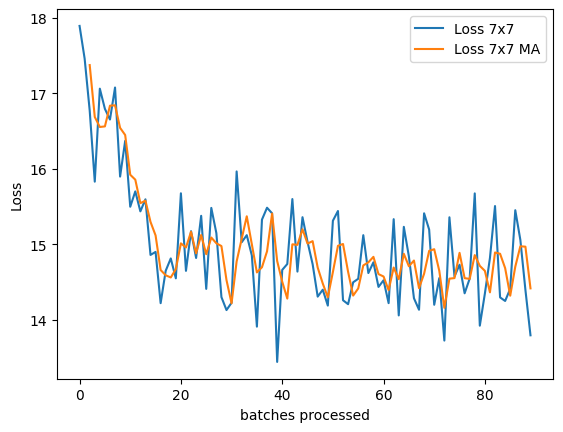

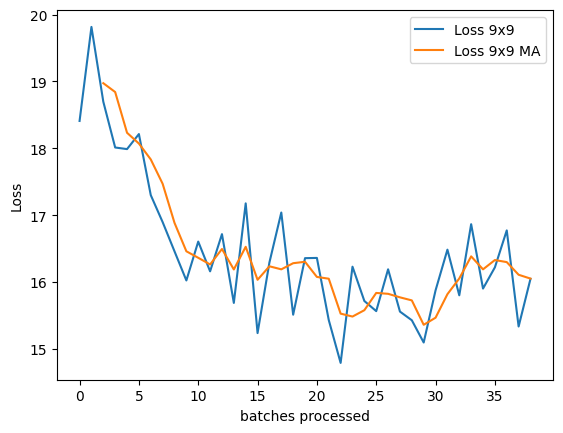

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

loss_7x7 = pd.read_csv("../Results/loss_Go7x7.csv")
loss_9x9 = pd.read_csv("../Results/loss_Go9x9.csv", )

loss_7x7['loss'] = loss_7x7['loss'].str.extract(r'tf\.Tensor\(([\d.]+),', expand=False).astype(float)
loss_9x9['loss'] = loss_9x9['loss'].str.extract(r'tf\.Tensor\(([\d.]+),', expand=False).astype(float)

loss_7x7['Moving Average'] = loss_7x7['loss'].rolling(window=3).mean()
loss_9x9['Moving Average'] = loss_9x9['loss'].rolling(window=3).mean()

plt.plot(loss_7x7['loss'], label="Loss 7x7")
plt.plot(loss_7x7['Moving Average'], label="Loss 7x7 MA")
plt.ylabel("Loss")
plt.xlabel("batches processed")
plt.legend()
plt.show()

plt.plot(loss_9x9["loss"], label="Loss 9x9")
plt.plot(loss_9x9["Moving Average"], label="Loss 9x9 MA")
plt.ylabel("Loss")
plt.xlabel("batches processed")
plt.legend()
plt.show()